### Imports, downloading the MNIST dataset, and defining system paths to the sub-sets of data.

In [5]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

import deeptrack as dt
from deeptrack.extras import datasets

# Download MNIST
datasets.load('MNIST')

PATH_TO_DATASET = os.path.abspath('./datasets/MNIST')

TRAINING_SET_PATH = os.path.join(PATH_TO_DATASET, 'training_set.npy')
TRAINING_LABELS_PATH = os.path.join(PATH_TO_DATASET, 'training_labels.npy')
VALIDATION_SET_PATH = os.path.join(PATH_TO_DATASET, 'validation_set.npy')
VALIDATION_LABELS_PATH = os.path.join(PATH_TO_DATASET, 'validation_labels.npy')

MNIST already downloaded! Use force_overwrite=True to redownload the dataset.


### Loading image data

**NOTE**

Here we load image data using a dt method, is this a open CV method in disguise or is it doing something very different in order to create a "feature"?

In [6]:
get_training_images = dt.LoadImage(path=TRAINING_SET_PATH)
get_training_labels = dt.LoadImage(path=TRAINING_LABELS_PATH)

get_validation_images = dt.LoadImage(path=VALIDATION_SET_PATH)
get_validation_labels = dt.LoadImage(path=VALIDATION_LABELS_PATH)

**NOTE**

Normalizing image values to between 0 and 1. Confused about why this needs to be done using the dt function, probably due to how features behave?

In [7]:
normalization = dt.NormalizeMinMax(0,1)

get_training_images += normalization
get_validation_images += normalization

**NOTE**

Here the resolution gives us regular ndarrays, I'm assuming?

In [8]:
training_images = get_training_images.resolve()
training_labels = get_training_labels.resolve()

validation_images = get_validation_images.resolve()
validation_labels = get_validation_labels.resolve()

**NOTE**

I have to read up on itertools and what the hell is happening here.

In [9]:
training_data_iterator = itertools.cycle(training_images)
training_label_iterator = itertools.cycle(training_labels)

training_iterator = dt.Dataset(
    data = training_data_iterator,
    label = training_label_iterator
)

**NOTE**

How are these values arrived at? Any tips?

I read in the dt.Affine() doc that the order relates to how pixevalues should be interpolated whenever it is needed. It says order 2 is not recommended by skimage, what does this mean and is it relevant to us?

I didn't see any description of what mode does in the doc, what is it? I see that it is described in the dt.ElasticTransformation() docs, maybe it should be added to the dt.Affine docstring? I still don't quite understand what it does though.

In [10]:
# Scale values in x,y
scale = {
    'x': lambda: 0.8 + np.random.rand() * 0.4,
    'y': lambda: 0.8 + np.random.rand() * 0.4
}

# Translation values in x and y
translate_px = {
    'x': lambda: int(np.random.randint(-2,3)),
    'y': lambda: int(np.random.randint(-2,3))
}

# Rotation or shear flag
should_rotate = lambda: np.random.randint(2)

# If rotate, how much?
rotate = lambda should_rotate: (-0.35 + np.random.rand() * 0.7) * should_rotate

# If shear, how much?
shear = lambda should_rotate: (-0.35 + np.random.rand() * 0.7) * (1 - should_rotate)

affine_transform = dt.Affine(
    scale = scale,
    translate_px = translate_px,
    should_rotate = should_rotate,
    shear = shear,
    order = 2,
    mode = 'constant'
)

**NOTE**

Is elastic transformation just a "continuous" (discrete) deformation, like in topology?

In [11]:
elastic_transform = dt.ElasticTransformation(
    alpha = lambda: np.random.rand() * 60, # Amplitude of distortions
    sigma = lambda: 5 + np.random.rand() * 2, # Granularity of distortions
    ignore_last_dim = False, # Last dimension is not a channel, so it should be augmented
    mode = 'constant'
)

**NOTE**

Here we clip the images, why not renormalize?

In [12]:
clip = dt.Clip(0,1)

**NOTE**

Is it important that we perform the elastic transformation before the affine ones?

In [13]:
augmentation = elastic_transform + affine_transform + clip
augmented_training_set = training_iterator + augmentation

In [14]:
def get_label(image): return image.get_property('label')

***NOTE***

How does figsize work? It behaves a little weirdly, maybe it is constrained by the imagesizes?

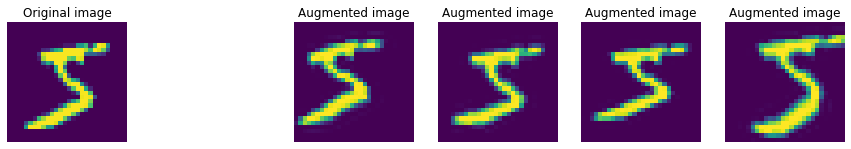

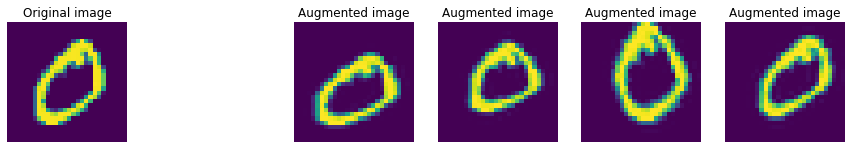

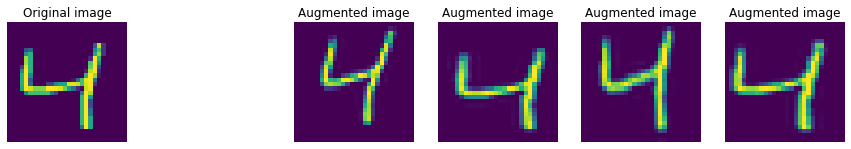

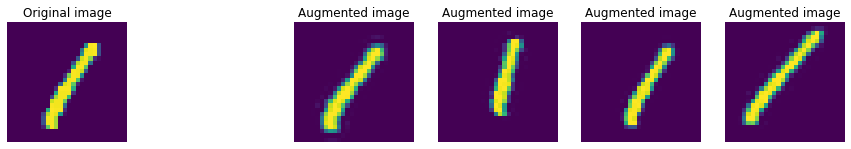

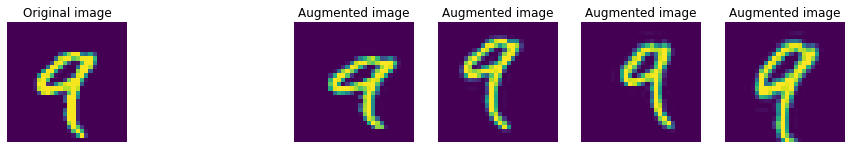

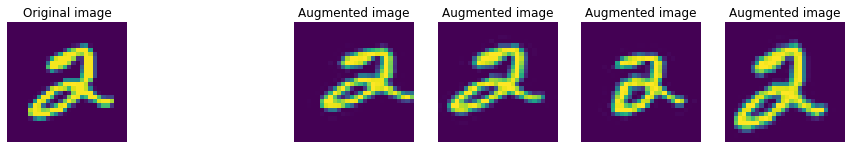

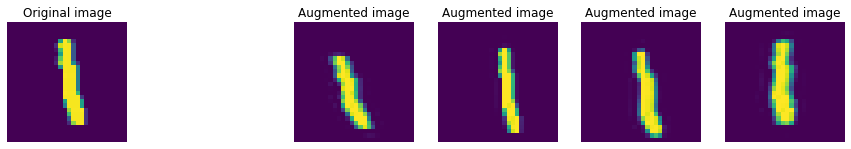

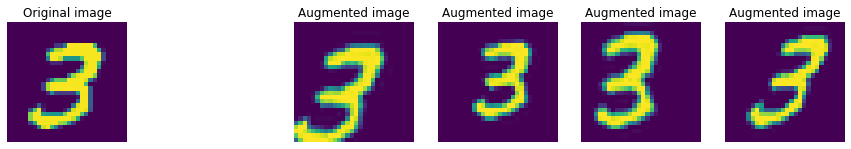

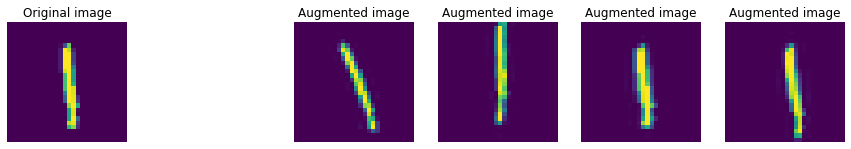

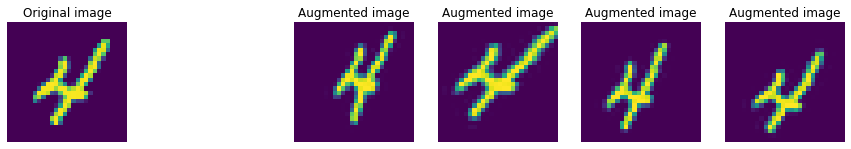

In [15]:
NUMBER_OF_IMAGES = 10

for image_index in range(NUMBER_OF_IMAGES):
    augmented_training_set.update()

    original_image = training_iterator.resolve()

    plt.figure(figsize=(15,13))
    plt.subplot(1,6,1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original image")

    for sub_plt in range(3,7):
        # Only update the augmentation
        augmentation.update()
        augmented_image = augmented_training_set.resolve()
        plt.subplot(1, 6, sub_plt)
        plt.imshow(augmented_image)
        plt.axis('off')
        plt.title("Augmented image")
plt.show()

**NOTE**

What is the dropout parameter? It doesn't seem to be included in the docstring.

I'm guessing this is where most of what we need to learn is. General talking points on choosing type of model, model parameters and adjusting hyperparameters would be awesome!

In [16]:
model = dt.models.FullyConnected(
    input_shape = (28, 28),
    dense_layers_dimensions = (2000, 1500, 1000, 500),
    number_of_outputs = 10,
    dropout = (0.25, 0.25),
    output_activation = 'softmax',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = 'rmsprop'
)

2022-01-23 18:32:15.747701: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
TRAIN_MODEL = False

if TRAIN_MODEL:
    generator = dt.generators.Generator().generate(
        augmented_training_set,
        get_label,
        batch_size = 64
    )

    h = model.fit(
        generator,
        validation_data = (validation_images, 
                           validation_labels),
        steps_per_epoch = 100,
        epochs = 200
    )

    plt.plot(h.history["loss"], 'g')
    plt.plot(h.history["val_loss"], 'r')
    plt.legend(["Loss", "Validation loss"])
    plt.yscale("log")
    plt.show()

else:
    model_path = datasets.load_model("MNIST")
    model.load_weights(model_path)

Download Complete!


In [20]:
array_of_images = validation_images
array_of_labels = validation_labels

predicted_digits = np.argmax(model.predict(array_of_images), axis = 1)

accuracy = np.mean(np.array(array_of_labels) == predicted_digits)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)

Accuracy: 0.9921
Error rate: 0.007900000000000018


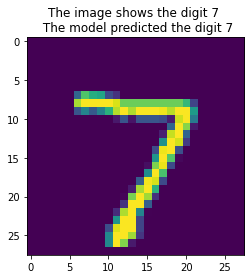

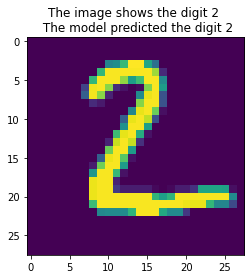

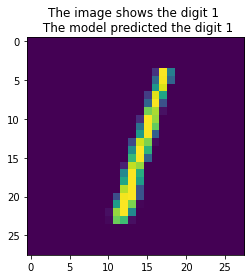

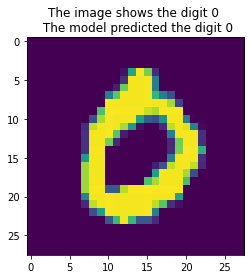

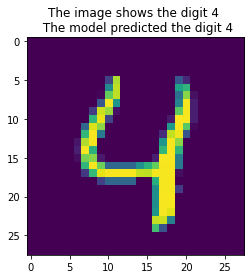

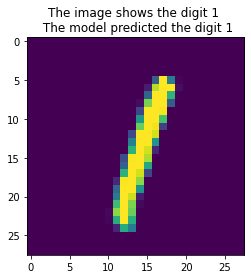

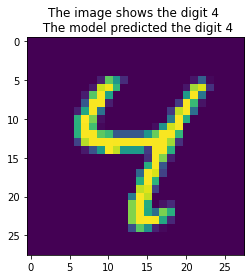

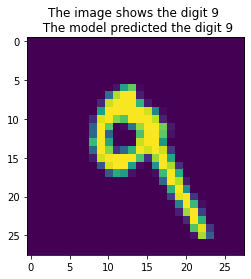

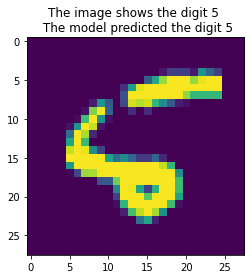

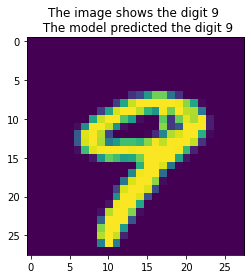

In [24]:
TITLE_STRING = "The image shows the digit {0} \n The model predicted the digit {1}"

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_labels[image_index], predicted_digits[image_index]))
    plt.show()

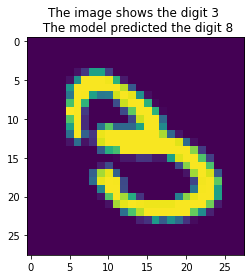

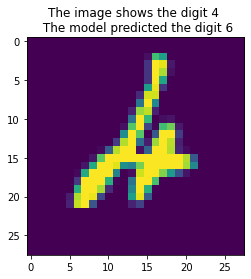

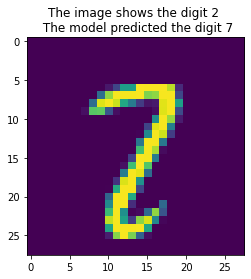

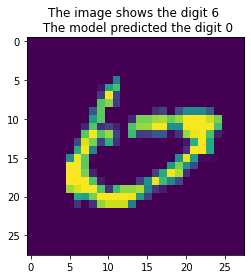

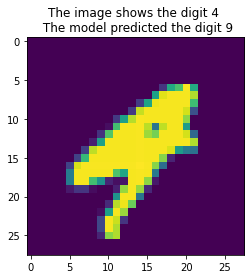

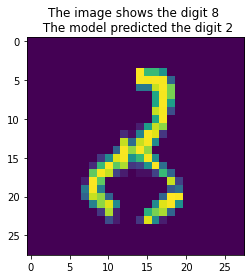

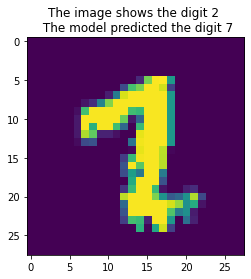

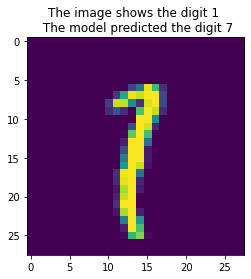

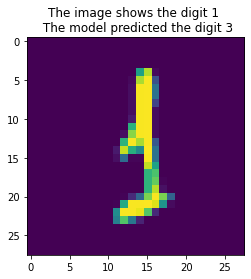

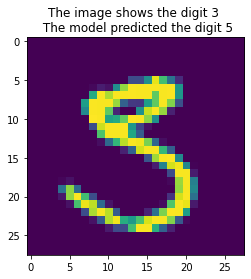

In [25]:
TITLE_STRING = "The image shows the digit {0} \n The model predicted the digit {1}"

model_is_wrong = predicted_digits != array_of_labels

array_of_hard_images = array_of_images[model_is_wrong]
array_of_hard_labels = array_of_labels[model_is_wrong]
innacurately_predicted_digits = predicted_digits[model_is_wrong]

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_hard_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_hard_labels[image_index], innacurately_predicted_digits[image_index]))
    plt.show()